# NYC Rideshare Forecasting Pipeline — Part 4: Demand Forecasting

**Author:** K Flowers  
**GitHub:** https://github.com/KRFlowers  
**Date:** December 2025

This notebook forecasts daily NYC rideshare demand (Uber/Lyft). Three models are compared: Seasonal Naive, Prophet, and XGBoost. These models were selected based on EDA findings of dominant weekly patterns.

**Pipeline Position:** Notebook 4 of 4 — Demand Forecasting

- 00_data_download.ipynb  
- 01_data_validation.ipynb  
- 02_exploratory_analysis.ipynb  
- 03_demand_forecasting.ipynb ← **this notebook**

**Objective:** Build a forecasting model that predicts daily trips by zone, targeting <10% MAPE.

**Technical Approach:**
- Compare three models (Seasonal Naive, Prophet, XGBoost) on dataset containing high-correlation zones (82% of trips)
- Perform feature engineering with lag-based features (7-day) aligned with weekly patterns identified during EDA
- Build and evaluate models on a pilot zone prior to scaling
- Scale best model to all zones
- Forecast one-day-ahead to keep initial modeling straightforward

**Inputs:**
- `zone_daily_high_corr.parquet` — High-correlation zones (195 zones - modeling subset)
- `data/raw/zone_metadata.csv` — Zone names and borough mappings

**Outputs:**
- `data/results/forecast_results.csv` — Daily forecasts with error metrics
- `data/results/summary_results.csv` — Zone-level performance summary

**Runtime:** ~15 minutes

## Model Selection Rationale

Based on the EDA findings of dominant weekly seasonality and stable within-zone demand, three forecasting approaches are compared: Seasonal Naive baseline, Prophet, and XGBoost.

**Seasonal Naive (Baseline):**  
A simple benchmark using a 7-day lag to reflect observed weekly patterns (same day last week). 

**Prophet:**  
A time series model designed for forcasting with complex trend and seasonality. Will be configured to capture weekly patterns while automatically handling holidays and missing data.

**XGBoost:**  
A gradient boosting model which will be adapted for time series by adding calendar/date lag-based feature engineering. 

**Approach Rationale:**  
One-day-ahead forecasting is used as a proof of concept to validate model performance before extending to longer horizons. This keeps the initial analysis simple and establishes a foundation for future multi-day forecasting.

## 1. Configure Environment

### 1.1 Import Libraries

In [1]:
# Configuration (must be set before other imports to suppress warnings)
import warnings
warnings.filterwarnings('ignore')

# Core libraries
import pandas as pd
import numpy as np
from pathlib import Path

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Modeling
from prophet import Prophet
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Logging
import logging

print("Libraries imported successfully")

Importing plotly failed. Interactive plots will not work.


Libraries imported successfully


### 1.2 Set Display and Plot Options

In [2]:
# Display settings
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', '{:.4f}'.format)

# Visualization settings
sns.set_palette('husl')
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams.update({
    'figure.figsize': (12, 4),
    'axes.titlesize': 10,
    'axes.labelsize': 9,
    'xtick.labelsize': 8,
    'ytick.labelsize': 8,
    'legend.fontsize': 8,
    'legend.framealpha': 0.9,
    'grid.alpha': 0.3,
    'axes.grid': True,
    'axes.grid.axis': 'y'
})
%matplotlib inline

warnings.filterwarnings('ignore')
#logging.getLogger('cmdstanpy').setLevel(logging.WARNING)

print(f"Display options set")

Display options set


### 1.3 Set Paths and Constants

In [3]:
# Paths
PROJECT_ROOT = Path("..").resolve()
PROCESSED_DIR = PROJECT_ROOT / "data" / "processed"
RESULTS_DIR = PROJECT_ROOT / "data" / "results"

# Input Files
ZONE_DAILY_FILE = PROCESSED_DIR / "zone_daily_high_corr.parquet"
ZONE_METADATA_FILE = PROJECT_ROOT / "data" / "raw" / "zone_metadata.csv"

# Output Files
FORECAST_RESULTS_FILE = RESULTS_DIR / "forecast_results.csv"
SUMMARY_RESULTS_FILE = RESULTS_DIR / "summary_results.csv"

# Model Parameters
TRAIN_END_DATE = '2024-06-30'
TEST_START_DATE = '2024-07-01'
TEST_END_DATE = '2024-12-31'

# Create Directory
RESULTS_DIR.mkdir(parents=True, exist_ok=True)

print(f"Paths and constants defined")

Paths and constants defined


### 1.4 Define Helper Functions

- **MAE** (Mean Absolute Error): Used to compare and select the best model
- **MAPE** (Mean Absolute Percentage Error): Used to compare performance (target: <10%)
- **RMSE** (Root Mean Squared Error): Included for possible future use

In [4]:
# Create an evaluation function to ensure consistent model comparison with standard metrics across all models (MAE, RMSE, MAPE)

def evaluate_forecast(
    actual: np.ndarray, 
    predicted: np.ndarray, 
    model_name: str = "Model"
) -> dict:
    """Calculate forecast accuracy metrics.
    
    Args:
        actual: Array of actual values
        predicted: Array of predicted values  
        model_name: Name identifier for the model
        
    Returns:
        Dictionary with Model name, MAE, RMSE, and MAPE metrics
    """
    # Convert to numpy arrays to ensure positional alignment
    actual = np.array(actual)
    predicted = np.array(predicted)
    
    mae = mean_absolute_error(actual, predicted)
    rmse = np.sqrt(mean_squared_error(actual, predicted))
    
    # Exclude zero-demand days from MAPE (avoids division by zero)
    mask = actual > 0
    mape = np.mean(np.abs((actual[mask] - predicted[mask]) / actual[mask])) * 100
    
    return {
        'Model': model_name,
        'MAE': round(mae, 2),
        'RMSE': round(rmse, 2),
        'MAPE': round(mape, 2)
    }

print("Evaluation function defined")

Evaluation function defined


## 2. Load and Explore Data

## DataFrame Reference
**Base Data**
- `full_df` — All 195 zones, full date range
- `pilot_df` — Pilot zone only, full date range

**Train/Test Splits**
- `full_train_df`, `full_test_df` — All zones split by date
- `pilot_train_df`, `pilot_test_df` — Pilot zone split by date

**Model-Specific** (transformed from base splits)
- `xgb_full_df`, `xgb_pilot_df` — With lag features added
- `prophet_train_df`, `prophet_test_df` — With ds/y column naming

**Results**
- `pilot_results_df` — Model comparison metrics (Baseline, Prophet, XGBoost)
- `forecast_df` — All-zones daily forecasts with actuals
- `zone_summary_df` — Zone-level aggregated metrics (MAE, MAPE)

### 2.1 Load Data and Create Base Datasets
Load high-correlation zones dataset (195 zones, 82% of trips) and select pilot zone with highest correlation to global patterns.

In [5]:
# 2.1 Load Data
zone_daily_df = pd.read_parquet(ZONE_DAILY_FILE)
zone_metadata_df = pd.read_csv(ZONE_METADATA_FILE)
zone_stats_df = pd.read_csv(PROCESSED_DIR / "zone_stats_summary.csv")

# Ensure zone_id is integer type
zone_daily_df['zone_id'] = zone_daily_df['zone_id'].astype(int)

# Sort data and reset index
zone_daily_df = (
    zone_daily_df
    .sort_values(["zone_id", "date"])
    .reset_index(drop=True)
)

# 2.2 Select Pilot Zone (highest correlation to global patterns)
PILOT_ZONE_ID = int(zone_stats_df.sort_values('correlation_to_global', ascending=False).iloc[0]['zone_id'])
PILOT_ZONE_NAME = zone_metadata_df.loc[zone_metadata_df['zone_id'] == PILOT_ZONE_ID, 'Zone'].values[0]

# 2.3 Create Base Datasets
full_df = zone_daily_df.copy()
pilot_df = zone_daily_df[zone_daily_df['zone_id'] == PILOT_ZONE_ID].copy()

print(f"Data loaded:")
print(f"  full_df: {len(full_df):,} records ({full_df['zone_id'].nunique()} zones)")
print(f"  pilot_df: {len(pilot_df):,} records (Zone {PILOT_ZONE_ID} - {PILOT_ZONE_NAME})")
print(f"  Date range: {full_df['date'].min().date()} to {full_df['date'].max().date()}")

Data loaded:
  full_df: 213,720 records (195 zones)
  pilot_df: 1,096 records (Zone 41 - Central Harlem)
  Date range: 2022-01-01 to 2024-12-31


### 2.2 Review Dataset Structure

In [6]:
# Display dataset overview
print("Dataset Overview")
print(f"  Source: {ZONE_DAILY_FILE.name}")
print(f"  Zones: {zone_daily_df['zone_id'].nunique()}")
print(f"  Date range: {zone_daily_df['date'].min()} to {zone_daily_df['date'].max()}")
print(f"  Total records: {len(zone_daily_df):,}")
print(f"  Days per zone: {len(zone_daily_df) / zone_daily_df['zone_id'].nunique():.0f}")

# Display column structure
print(f"\nDataset Structure")
print(f"  Shape: {zone_daily_df.shape}")
print(f"  Columns: {list(zone_daily_df.columns)}")

# Show sample records
zone_daily_df.head()

Dataset Overview
  Source: zone_daily_high_corr.parquet
  Zones: 195
  Date range: 2022-01-01 00:00:00 to 2024-12-31 00:00:00
  Total records: 213,720
  Days per zone: 1096

Dataset Structure
  Shape: (213720, 17)
  Columns: ['zone_id', 'date', 'daily_trips', 'daily_total_minutes', 'daily_avg_minutes', 'total_trip_miles', 'avg_trip_miles', 'total_fare', 'avg_fare', 'year', 'month', 'day_of_week', 'day_name', 'is_weekend', 'season', 'is_holiday', 'month_name']


,zone_id,date,daily_trips,daily_total_minutes,daily_avg_minutes,total_trip_miles,avg_trip_miles,total_fare,avg_fare,year,month,day_of_week,day_name,is_weekend,season,is_holiday,month_name
0,3,2022-01-01,908,754940.0000,831.4317,4369.0870,4.8118,16304.1300,17.9561,2022,1,5,Saturday,True,winter,False,January
1,3,2022-01-02,775,623338.0000,804.3071,3639.4760,4.6961,13118.2200,16.9267,2022,1,6,Sunday,True,winter,False,January
2,3,2022-01-03,1016,808724.0000,795.9882,4475.0630,4.4046,16348.2300,16.0908,2022,1,0,Monday,False,winter,False,January
3,3,2022-01-04,954,744883.0000,780.7998,3859.5230,4.0456,14844.7500,15.5605,2022,1,1,Tuesday,False,winter,False,January
4,3,2022-01-05,1046,858899.0000,821.1272,4289.9420,4.1013,16761.3500,16.0242,2022,1,2,Wednesday,False,winter,False,January


### 2.3 Verify Data Completeness

In [7]:
# Check for missing values
print("Data Completeness Check")
print(f"  Missing values: {zone_daily_df.isnull().sum().sum()}")

Data Completeness Check
  Missing values: 0


## 3. Create Train/Test Datasets

### 3.1 Create Train/Test Split
Train on Jan 2022–Jun 2024, test on Jul–Dec 2024.

In [8]:
# 3.1 Split Full Dataset
full_train_df = full_df[full_df['date'] <= TRAIN_END_DATE].copy()
full_test_df = full_df[full_df['date'] >= TEST_START_DATE].copy()

# 3.2 Split Pilot Dataset
pilot_train_df = pilot_df[pilot_df['date'] <= TRAIN_END_DATE].copy()
pilot_test_df = pilot_df[pilot_df['date'] >= TEST_START_DATE].copy()

print("Train/Test Split")
print(f"\n  Full Train:  {full_train_df['date'].min().date()} to {full_train_df['date'].max().date()} ({len(full_train_df):,} rows)")
print(f"  Full Test:   {full_test_df['date'].min().date()} to {full_test_df['date'].max().date()} ({len(full_test_df):,} rows)")
print(f"\n  Pilot Train: {len(pilot_train_df):,} rows")
print(f"  Pilot Test:  {len(pilot_test_df):,} rows")

Train/Test Split

  Full Train:  2022-01-01 to 2024-06-30 (177,840 rows)
  Full Test:   2024-07-01 to 2024-12-31 (35,880 rows)

  Pilot Train: 912 rows
  Pilot Test:  184 rows


In [9]:
# 3.3 Validate Splits
assert full_train_df['date'].max() < full_test_df['date'].min(), "Data leakage: train/test overlap"
assert len(full_train_df) + len(full_test_df) == len(full_df), "Records lost in split"

print("Split validated: no overlap, no missing records")

Split validated: no overlap, no missing records


## 4. Build Baseline Model (Seasonal Naive)
Establish a simple benchmark using 7-day lag forecasting to preserve day-of-week alignment.

### 4.1 Prepare Data
No special preparation needed - baseline uses raw test data with 7-day shift. 

### 4.2 Train Model
Apply seasonal naive forecasting rule by creating a 7-day lag variable.

In [10]:
# Apply baseline forecasting rule with 7-day lag to full pilot zone data (before train/test split)
pilot_df['baseline_pred'] = pilot_df['daily_trips'].shift(7)

### 4.3 Generate Forecast
Filter to test period and extract baseline predictions.

In [11]:
# Filter to test period for evaluation
baseline_test_df = pilot_df[pilot_df['date'] >= TEST_START_DATE].copy().sort_values('date').reset_index(drop=True)

print(f"Baseline forecast generated: {len(baseline_test_df)} days")
print(f"Missing values: {baseline_test_df['baseline_pred'].isna().sum()}")

Baseline forecast generated: 184 days
Missing values: 0


### 4.4 Evaluate Results
Calculate forecast accuracy metrics and compare to zone mean demand.

In [12]:
# Calculate baseline metrics
baseline_results = evaluate_forecast(
    baseline_test_df['daily_trips'], 
    baseline_test_df['baseline_pred'],
    model_name="Baseline (Seasonal Naive)"
)

# Calculate zone mean for context
zone_mean = pilot_train_df['daily_trips'].mean()

print(f"BASELINE PERFORMANCE (Zone {PILOT_ZONE_ID} - {PILOT_ZONE_NAME})")
print(f"\nZone mean demand: {zone_mean:,.0f} trips/day")
print(f"MAE:  {baseline_results['MAE']:,.0f} trips/day ({baseline_results['MAE']/zone_mean*100:.1f}% of mean)")
print(f"RMSE: {baseline_results['RMSE']:,.0f} trips/day")
print(f"MAPE: {baseline_results['MAPE']:.1f}%")

BASELINE PERFORMANCE (Zone 41 - Central Harlem)

Zone mean demand: 3,992 trips/day
MAE:  297 trips/day (7.4% of mean)
RMSE: 393 trips/day
MAPE: 7.1%


**Results:** 
- The Seasonal Naive baseline achieved 7.1% MAPE
- Confirms weekly patterns identified in EDA capture most demand variation
- Possible Limitation: Seasonal Naive may miss recent demand changes since it always looks back exactly one week

### 4.5 Visualize Results
Plot baseline forecast against actual demand to assess performance.

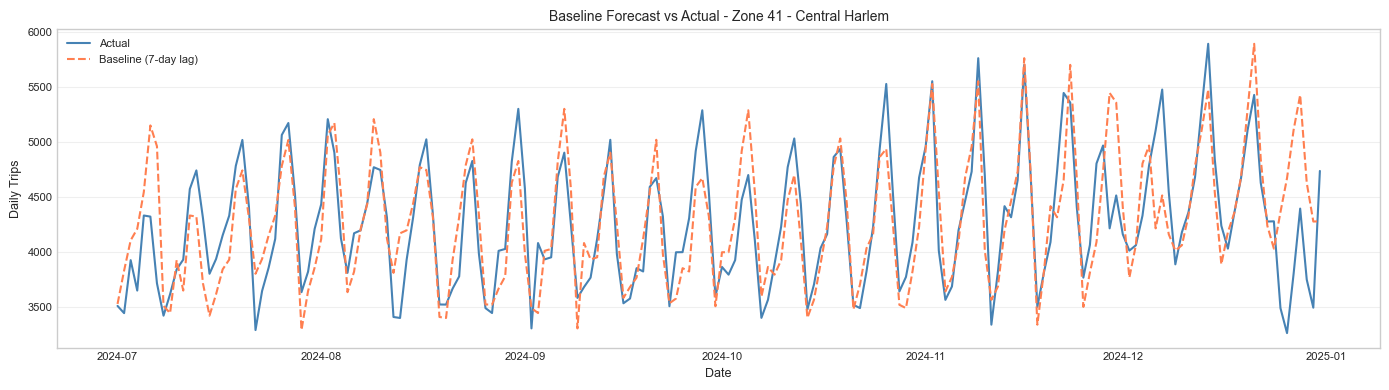

In [13]:
# Plot baseline forecast vs actual demand

fig, ax = plt.subplots(figsize=(14, 4))

ax.plot(baseline_test_df['date'], baseline_test_df['daily_trips'], 
        label='Actual', color='steelblue', linewidth=1.5)
ax.plot(baseline_test_df['date'], baseline_test_df['baseline_pred'], 
        label='Baseline (7-day lag)', color='coral', linewidth=1.5, linestyle='--')

ax.set_xlabel('Date')
ax.set_ylabel('Daily Trips')
ax.set_title(f'Baseline Forecast vs Actual - Zone {PILOT_ZONE_ID} - {PILOT_ZONE_NAME}')
ax.legend()
plt.tight_layout()
plt.show()

## 5. Build Prophet Model
Train Prophet on the pilot zone. Configure with additive seasonality and weekly patterns based on EDA findings.

### 5.1 Prepare Data

In [14]:
# Prophet uses pilot_train_df and pilot_test_df created in Section 3
# Format data for Prophet (requires 'ds' and 'y' columns)
prophet_train_df = pilot_train_df[['date', 'daily_trips']].copy()
prophet_train_df.columns = ['ds', 'y']

prophet_test_df = pilot_test_df[['date', 'daily_trips']].copy()
prophet_test_df.columns = ['ds', 'y']

print(f"Prophet train shape: {prophet_train_df.shape}")
print(f"Prophet test shape: {prophet_test_df.shape}")

Prophet train shape: (912, 2)
Prophet test shape: (184, 2)


### 5.2 Train Model

In [15]:
# Initialize Prophet focused on dominant weekly seasonality
# EDA suggests additive structure (variation does not scale with demand level)

model_prophet = Prophet(
    yearly_seasonality=False,     # Evaluate yearly during tuning if needed
    weekly_seasonality=True,
    daily_seasonality=False,      # Data is daily aggregated
    seasonality_mode='additive',  # EDA showed volatility does not increase with demand
    changepoint_prior_scale=0.05  # Controls trend flexibility (reasonable default)
)

In [16]:
# Train model
model_prophet.fit(prophet_train_df)

print("Prophet model trained")

11:57:29 - cmdstanpy - INFO - Chain [1] start processing


11:57:30 - cmdstanpy - INFO - Chain [1] done processing


Prophet model trained


### 5.3 Generate Forecast

In [17]:
# Generate predictions for test period
future = prophet_test_df[['ds']].copy()
prophet_forecast_df = model_prophet.predict(future)

# Store predictions
pilot_test_df['prophet_pred'] = prophet_forecast_df['yhat'].values

print(f"Prophet forecast generated: {len(prophet_forecast_df)} days")

Prophet forecast generated: 184 days


### 5.4 Evaluate Results

In [18]:
# Calculate Prophet metrics and compare to baseline
prophet_results = evaluate_forecast(
    prophet_test_df['y'],
    prophet_forecast_df['yhat'],
    model_name="Prophet"
)

# Calculate improvement over baseline
improvement_prophet = (baseline_results['MAE'] - prophet_results['MAE']) / baseline_results['MAE'] * 100

print(f"PROPHET PERFORMANCE")
print(f"\nZone mean demand: {zone_mean:,.0f} trips/day")
print(f"MAE:  {prophet_results['MAE']:,.0f} trips/day")
print(f"RMSE: {prophet_results['RMSE']:,.0f} trips/day")
print(f"MAPE: {prophet_results['MAPE']:,.1f}%")
print(f"\nImprovement over baseline: {improvement_prophet:+.1f}%")

PROPHET PERFORMANCE

Zone mean demand: 3,992 trips/day
MAE:  528 trips/day
RMSE: 627 trips/day
MAPE: 13.2%

Improvement over baseline: -77.7%


**Results:**
- The Prophet model achieved 13.2% MAPE
- This underperforms the baseline by 6.1 percentage points
- Possible Limitation: Prophet is designed for longer time periods where seasonality and trend are complex and matter more than recent demand. For 1 day ahead forecasting it may not be a suitable model, however, for 1-2 week forecasts, it may actually perform better

### 5.5 Visualize Results

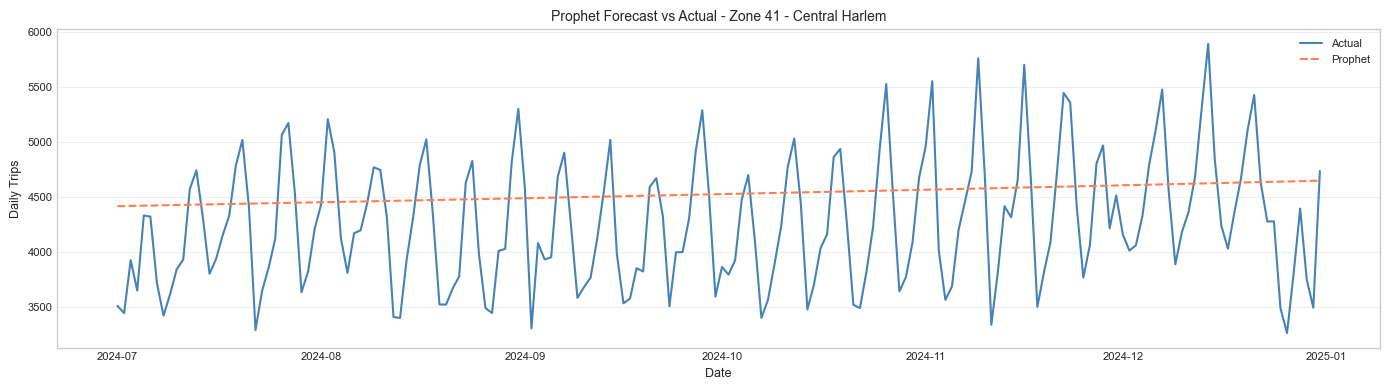

In [19]:
# Plot Prophet forecast vs actual demand

fig, ax = plt.subplots(figsize=(14, 4))

ax.plot(pilot_test_df['date'], pilot_test_df['daily_trips'], 
        label='Actual', color='steelblue', linewidth=1.5)
ax.plot(pilot_test_df['date'], pilot_test_df['prophet_pred'], 
        label='Prophet', color='coral', linewidth=1.5, linestyle='--')

ax.set_xlabel('Date')
ax.set_ylabel('Daily Trips')
ax.set_title(f'Prophet Forecast vs Actual - Zone {PILOT_ZONE_ID} - {PILOT_ZONE_NAME}')
ax.legend()
plt.tight_layout()
plt.show()

### 5.6 Tune Parameters
Evaluate multiplicative seasonality and yearly patterns to test if alternative configurations improve performance.

In [20]:
# Quick test if tuning would result in meaningful improvements
configs = [
    {'name': 'Additive', 'mode': 'additive'},
    {'name': 'Multiplicative', 'mode': 'multiplicative'},
]

print(f"PROPHET TUNING - Zone {PILOT_ZONE_ID}")
print("=" * 40)
print(f"Baseline MAE: {baseline_results['MAE']:,.0f}\n")

for config in configs:
    model = Prophet(
        yearly_seasonality=True,
        weekly_seasonality=True,
        daily_seasonality=False,
        seasonality_mode=config['mode'],
        changepoint_prior_scale=0.05
    )
    model.add_country_holidays(country_name='US')
    model.fit(prophet_train_df)
    
    forecast = model.predict(prophet_test_df[['ds']])
    mae = mean_absolute_error(prophet_test_df['y'].values, forecast['yhat'].values)
    vs_baseline = (baseline_results['MAE'] - mae) / baseline_results['MAE'] * 100
    
    print(f"{config['name']}: MAE {mae:,.0f} ({vs_baseline:+.1f}% vs baseline)")

PROPHET TUNING - Zone 41
Baseline MAE: 297



11:57:31 - cmdstanpy - INFO - Chain [1] start processing


11:57:31 - cmdstanpy - INFO - Chain [1] done processing


Additive: MAE 525 (-76.7% vs baseline)


11:57:31 - cmdstanpy - INFO - Chain [1] start processing


11:57:31 - cmdstanpy - INFO - Chain [1] done processing


Multiplicative: MAE 527 (-77.2% vs baseline)


**Results:**
- Prophet with multiplicative seasonality and yearly patterns also underperforms
- No configuration tested improved over baseline

---

## 6. Build XGBoost Model
Perform feature engineering, trains XGBoost, and analyzes feature importance.

### 6.1 Prepare Data

**Feature Selection Rationale:** Lag-7 was chosen as the primary predictor since EDA revealed stable weekly patterns. Additional features include lag-1 (for short-term trends), rolling_mean_7 (recent week average), and rolling_mean_28 (monthly baseline) to capture different time scales.

In [21]:
# Engineer lag features for XGBoost (XGBoost needs explicit features for time series modeling)

def create_lag_features(
    df: pd.DataFrame, 
    target_col: str = 'daily_trips', 
    lags: list[int] = [1, 7]
) -> pd.DataFrame:
    """Create lag_N and rolling_mean features for time series modeling."""
    df = df.copy()
    for lag in lags:
        df[f'lag_{lag}'] = df.groupby('zone_id')[target_col].shift(lag)
    
    # Rolling features
    df['rolling_mean_7'] = df.groupby('zone_id')[target_col].transform(
        lambda x: x.shift(1).rolling(7, min_periods=1).mean()
    )
    df['rolling_mean_28'] = df.groupby('zone_id')[target_col].transform(
        lambda x: x.shift(1).rolling(28, min_periods=1).mean()
    )
    return df

In [22]:
# Create lag features on full dataset (before split per plan)
xgb_full_df = create_lag_features(full_df.copy())

# Split after feature engineering
xgb_full_train_df = xgb_full_df[xgb_full_df['date'] <= TRAIN_END_DATE].copy()
xgb_full_test_df = xgb_full_df[xgb_full_df['date'] >= TEST_START_DATE].copy()

# Filter to pilot zone for pilot model testing
xgb_pilot_train_df = xgb_full_train_df[xgb_full_train_df['zone_id'] == PILOT_ZONE_ID].copy()
xgb_pilot_test_df = xgb_full_test_df[xgb_full_test_df['zone_id'] == PILOT_ZONE_ID].copy()

print(f"Lag features created: lag_1, lag_7, rolling_mean_7, rolling_mean_28")

Lag features created: lag_1, lag_7, rolling_mean_7, rolling_mean_28


In [23]:
# Select features to train XGBoost model

FEATURE_COLS = [
    # Time features (from EDA)
    'month', 'day_of_week', 'is_holiday',
    # Lag features
    'lag_1', 'lag_7',
    # Rolling features
    'rolling_mean_7', 'rolling_mean_28'
]

TARGET_COL = 'daily_trips'

# Remove rows with NaN from lag creation
xgb_pilot_train_df = xgb_pilot_train_df.dropna(subset=FEATURE_COLS)
xgb_pilot_test_df = xgb_pilot_test_df.dropna(subset=FEATURE_COLS)

X_train = xgb_pilot_train_df[FEATURE_COLS]
y_train = xgb_pilot_train_df[TARGET_COL]

X_test = xgb_pilot_test_df[FEATURE_COLS]
y_test = xgb_pilot_test_df[TARGET_COL]

print(f"Features: {len(FEATURE_COLS)}")
print(f"Train samples: {len(X_train)}")
print(f"Test samples: {len(X_test)}")

Features: 7
Train samples: 905
Test samples: 184


### 6.2 Train Model

In [24]:
# Fit XGBoost model on training data
model_xgb = XGBRegressor(
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    random_state=42,
    n_jobs=-1
)

model_xgb.fit(X_train, y_train)

print("XGBoost model trained")

XGBoost model trained


### 6.3 Generate Forecast

In [25]:
# Generate predictions on test set
xgb_pred = model_xgb.predict(X_test)

print(f"Predictions generated: {len(xgb_pred)} days")

Predictions generated: 184 days


### 6.4 Evaluate Results

In [26]:
# Calculate XGBoost metrics and compare to baseline

xgb_results = evaluate_forecast(
    y_test.values, 
    xgb_pred,
    model_name="XGBoost"
)

# Calculate improvement over baseline
improvement_xgb = (baseline_results['MAE'] - xgb_results['MAE']) / baseline_results['MAE'] * 100

print(f"XGBOOST PERFORMANCE (Zone {PILOT_ZONE_ID} - {PILOT_ZONE_NAME})")
print(f"\nZone mean demand: {zone_mean:,.0f} trips/day")
print(f"MAE:  {xgb_results['MAE']:,.0f} trips/day ({xgb_results['MAE']/zone_mean*100:.1f}% of mean)")
print(f"RMSE: {xgb_results['RMSE']:,.0f} trips/day")
print(f"MAPE: {xgb_results['MAPE']:.1f}%")
print(f"\nImprovement over baseline: {improvement_xgb:+.1f}%")

XGBOOST PERFORMANCE (Zone 41 - Central Harlem)

Zone mean demand: 3,992 trips/day
MAE:  219 trips/day (5.5% of mean)
RMSE: 312 trips/day
MAPE: 5.1%

Improvement over baseline: +26.2%


**Results:**
- The XGBoost model achieved 5.1% MAPE
- This outperforms baseline by 2.0 percentage points
- Possible Explanation: By leveraging multiple lag-based features rather than a single weekly reference, the model adjusts more quickly during demand changes — the multiple lag features may be adjusting better compared to the single 7-day lag approach

### 6.5 Visualize Forecast
Compare XGBoost predictions against actual demand.

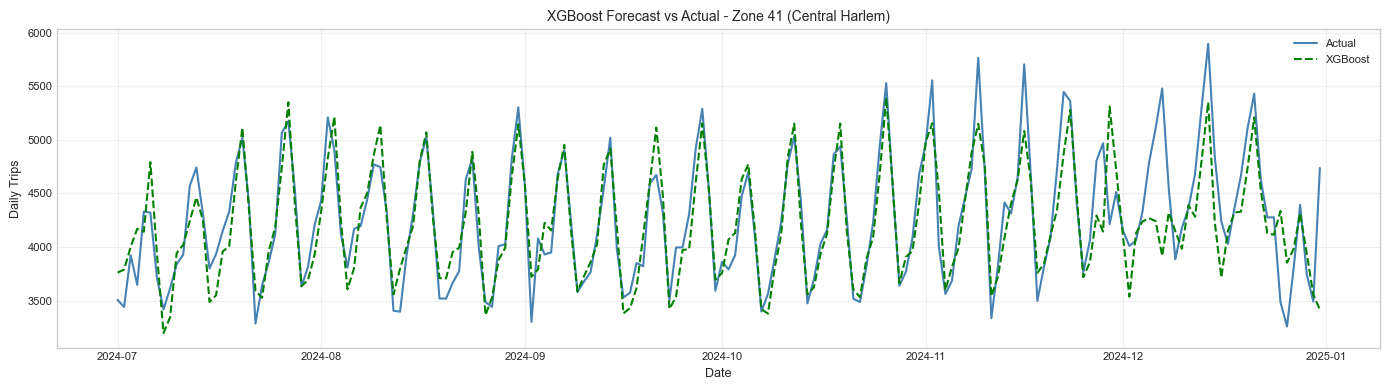

In [27]:
# Plot XGBoost forecast vs actual demand

fig, ax = plt.subplots(figsize=(14, 4))

ax.plot(xgb_pilot_test_df['date'], xgb_pilot_test_df['daily_trips'], 
        label='Actual', color='steelblue', linewidth=1.5)
ax.plot(xgb_pilot_test_df['date'], xgb_pred, 
        label='XGBoost', color='green', linewidth=1.5, linestyle='--')

ax.set_xlabel('Date')
ax.set_ylabel('Daily Trips')
ax.set_title(f'XGBoost Forecast vs Actual - Zone {PILOT_ZONE_ID} ({PILOT_ZONE_NAME})')
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

### 6.6 Visualize Feature Importance

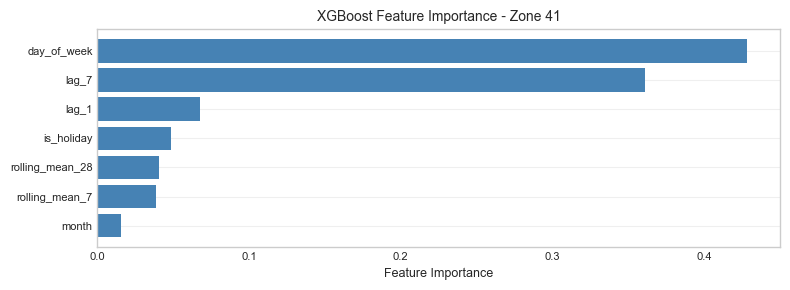

In [28]:
# Display XGBoost feature importance 

feature_importance_df = pd.DataFrame({
    'feature': FEATURE_COLS,
    'importance': model_xgb.feature_importances_
}).sort_values('importance', ascending=True)

fig, ax = plt.subplots(figsize=(8, 3))
ax.barh(feature_importance_df['feature'], feature_importance_df['importance'], color='steelblue')
ax.set_xlabel('Feature Importance')
ax.set_title(f'XGBoost Feature Importance - Zone {PILOT_ZONE_ID}')
plt.tight_layout()
plt.show()

**Results:**
- Feature importance shows day_of_week and lag_7 as top predictors
- This confirms the dominant weekly patterns shown in EDA

---

## 7. Compare Models
Compare model performance and select best approach for scaling.

### 7.1 Visualize Forecasts
Compare all three models against actual demand on pilot zone.

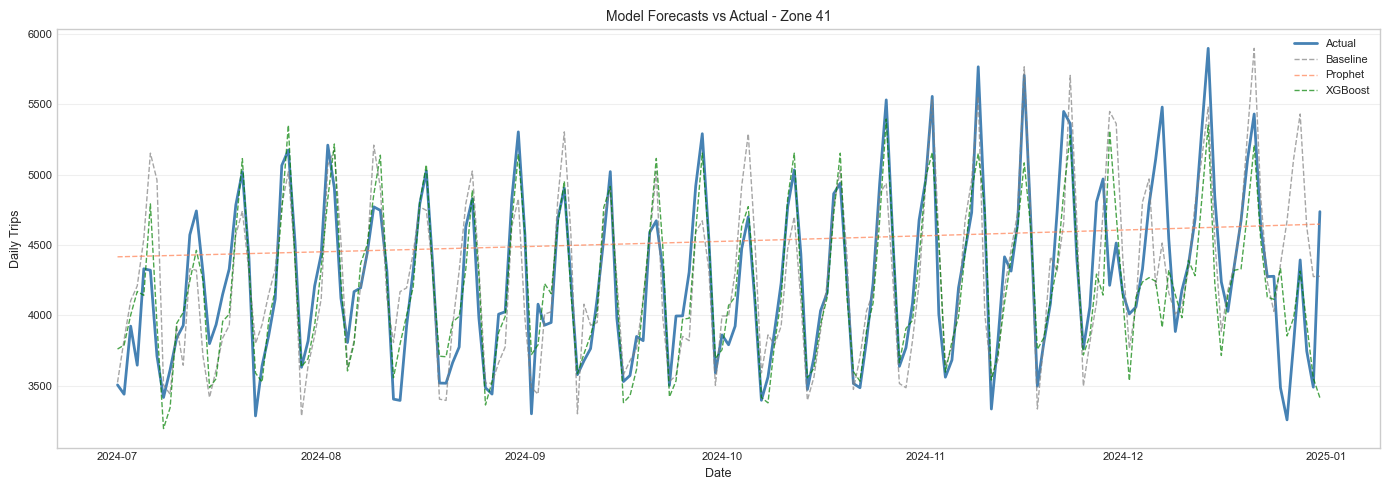

In [29]:
# Plot all forecasts against actual

fig, ax = plt.subplots(figsize=(14, 5))

ax.plot(pilot_test_df['date'], pilot_test_df['daily_trips'], 
        label='Actual', color='steelblue', linewidth=2)
ax.plot(baseline_test_df['date'], baseline_test_df['baseline_pred'], 
        label='Baseline', color='gray', linewidth=1, linestyle='--', alpha=0.7)
ax.plot(pilot_test_df['date'], pilot_test_df['prophet_pred'], 
        label='Prophet', color='coral', linewidth=1, linestyle='--', alpha=0.7)
ax.plot(xgb_pilot_test_df['date'], xgb_pred, 
        label='XGBoost', color='green', linewidth=1, linestyle='--', alpha=0.7)

ax.set_xlabel('Date')
ax.set_ylabel('Daily Trips')
ax.set_title(f'Model Forecasts vs Actual - Zone {PILOT_ZONE_ID}')
ax.legend()
plt.tight_layout()

# Save for README
fig.savefig('../images/forecast_vs_actual.png', dpi=150, bbox_inches='tight', facecolor='white')

plt.show()

**Results:**
- XGBoost (green) predicts actual demand most closely
- Baseline (gray) follows the pattern but lags one week behind
- Prophet (coral) appears nearly flat and not picking up a pattern

### 7.2 Select Best Model
Rank models by MAE and select best for final forecasting.

In [30]:
# Compare model performance and select winner

# Build comparison DataFrame from individual results
pilot_results_df = pd.DataFrame([baseline_results, prophet_results, xgb_results])

print(f"MODEL COMPARISON - Zone {PILOT_ZONE_ID} ({PILOT_ZONE_NAME})")
print("=" * 50)
print(pilot_results_df.sort_values('MAE').to_string(index=False))

best_model = pilot_results_df.loc[pilot_results_df['MAE'].idxmin(), 'Model']
best_mae = pilot_results_df['MAE'].min()
print(f"\nBest model: {best_model} (MAE: {best_mae:,.0f} trips/day)")

MODEL COMPARISON - Zone 41 (Central Harlem)
                    Model      MAE     RMSE    MAPE
                  XGBoost 219.1500 312.2200  5.0900
Baseline (Seasonal Naive) 297.1300 393.3200  7.0800
                  Prophet 527.8700 627.4200 13.1700

Best model: XGBoost (MAE: 219 trips/day)


##### Model Selection Reflection

**Why Prophet underperformed:** Prophet was designed for complex, irregular data with trend changes and messy seasonality (Taylor & Letham, 2018). This dataset's stable weekly patterns and low variability (CV < 0.3) may not benefit from that flexibility.

**Why XGBoost succeeded:** Gradient boosting methods are top performers on stable, high-frequency demand data (Makridakis et al., 2022). Explicit lag features directly captured the consistent weekly structure identified in EDA.

---

## 8. Scale Best Model
Scale the best performing model to all zones included in the input dataset.

### 8.1 Build Forecasting Pipeline
Create reusable function to train and forecast individual zones.

In [31]:
# Create reusable function to forecast a single zone with XGBoost - 1 time series

def forecast_zone_xgboost(
    zone_id: int, 
    train_df: pd.DataFrame, 
    test_df: pd.DataFrame, 
    feature_cols: list[str]
) -> pd.DataFrame:
    """Train XGBoost and generate forecasts for a single time-series (zone).
    
    Args:
        zone_id: Zone identifier to forecast
        train_df: Training data with all zones
        test_df: Test data with all zones
        feature_cols: List of feature column names
    
    Returns:
        DataFrame with row-level predictions for analysis and export
    """
    # Filter to zone
    zone_train = train_df[train_df['zone_id'] == zone_id].dropna(subset=feature_cols)
    zone_test = test_df[test_df['zone_id'] == zone_id].dropna(subset=feature_cols)
    
    X_train = zone_train[feature_cols]
    y_train = zone_train['daily_trips']
    X_test = zone_test[feature_cols]
    y_test = zone_test['daily_trips']
    
    # Train
    model = XGBRegressor(
        n_estimators=100,
        max_depth=6,
        learning_rate=0.1,
        random_state=42,
        n_jobs=-1
    )
    model.fit(X_train, y_train)
    
    # Return detailed results
    return pd.DataFrame({
        'zone_id': zone_id,
        'date': zone_test['date'].values,
        'actual': y_test.values,
        'forecast': model.predict(X_test),
        'day_name': zone_test['day_name'].values,
        'is_weekend': zone_test['is_weekend'].values,
        'is_holiday': zone_test['is_holiday'].values,
        'month': zone_test['month'].values,
        'season': zone_test['season'].values
    })

print("Forecasting pipeline defined")

Forecasting pipeline defined


### 8.2 Run Forecast on All Zones
Apply XGBoost model across all zones in dataset.

In [32]:
# Run forecasting pipeline on all zones in dataset

from tqdm import tqdm

zone_ids = xgb_full_df['zone_id'].unique().tolist()
all_forecasts = []

print(f"Forecasting {len(zone_ids)} zones in dataset...")

for zone_id in tqdm(zone_ids):
    try:
        zone_forecast = forecast_zone_xgboost(zone_id, xgb_full_train_df, xgb_full_test_df, FEATURE_COLS)
        all_forecasts.append(zone_forecast)
    except Exception as e:
        print(f"Zone {zone_id} failed: {e}")

# Combine into single DataFrame
forecast_df = pd.concat(all_forecasts, ignore_index=True)

print(f"\nCompleted: {forecast_df['zone_id'].nunique()} zones")
print(f"Total forecast records: {len(forecast_df):,}")

Forecasting 195 zones in dataset...


  0%|          | 0/195 [00:00<?, ?it/s]

  1%|          | 2/195 [00:00<00:18, 10.63it/s]

  2%|▏         | 4/195 [00:00<00:18, 10.29it/s]

  3%|▎         | 6/195 [00:00<00:18, 10.39it/s]

  4%|▍         | 8/195 [00:00<00:19,  9.57it/s]

  5%|▍         | 9/195 [00:00<00:19,  9.42it/s]

  5%|▌         | 10/195 [00:01<00:19,  9.47it/s]

  6%|▌         | 11/195 [00:01<00:19,  9.33it/s]

  6%|▌         | 12/195 [00:01<00:20,  8.94it/s]

  7%|▋         | 14/195 [00:01<00:19,  9.53it/s]

  8%|▊         | 16/195 [00:01<00:17, 10.07it/s]

  9%|▉         | 18/195 [00:01<00:16, 10.47it/s]

 10%|█         | 20/195 [00:01<00:16, 10.67it/s]

 11%|█▏        | 22/195 [00:02<00:15, 10.82it/s]

 12%|█▏        | 24/195 [00:02<00:16, 10.67it/s]

 13%|█▎        | 26/195 [00:02<00:17,  9.43it/s]

 14%|█▍        | 27/195 [00:02<00:18,  9.04it/s]

 14%|█▍        | 28/195 [00:02<00:18,  9.00it/s]

 15%|█▍        | 29/195 [00:02<00:18,  9.06it/s]

 15%|█▌        | 30/195 [00:03<00:18,  9.12it/s]

 16%|█▌        | 31/195 [00:03<00:18,  8.69it/s]

 16%|█▋        | 32/195 [00:03<00:19,  8.48it/s]

 17%|█▋        | 33/195 [00:03<00:20,  8.10it/s]

 17%|█▋        | 34/195 [00:03<00:20,  7.99it/s]

 18%|█▊        | 35/195 [00:03<00:20,  7.92it/s]

 18%|█▊        | 36/195 [00:03<00:19,  8.20it/s]

 19%|█▉        | 37/195 [00:03<00:18,  8.38it/s]

 19%|█▉        | 38/195 [00:04<00:18,  8.67it/s]

 20%|██        | 39/195 [00:04<00:18,  8.61it/s]

 21%|██        | 40/195 [00:04<00:17,  8.93it/s]

 22%|██▏       | 42/195 [00:04<00:15,  9.87it/s]

 23%|██▎       | 44/195 [00:04<00:14, 10.34it/s]

 24%|██▎       | 46/195 [00:04<00:14, 10.54it/s]

 25%|██▍       | 48/195 [00:05<00:13, 10.65it/s]

 26%|██▌       | 50/195 [00:05<00:13, 10.97it/s]

 27%|██▋       | 52/195 [00:05<00:12, 11.22it/s]

 28%|██▊       | 54/195 [00:05<00:12, 11.32it/s]

 29%|██▊       | 56/195 [00:05<00:13, 10.68it/s]

 30%|██▉       | 58/195 [00:05<00:14,  9.68it/s]

 30%|███       | 59/195 [00:06<00:14,  9.55it/s]

 31%|███▏      | 61/195 [00:06<00:13, 10.16it/s]

 32%|███▏      | 63/195 [00:06<00:12, 10.54it/s]

 33%|███▎      | 65/195 [00:06<00:12, 10.68it/s]

 34%|███▍      | 67/195 [00:06<00:11, 10.81it/s]

 35%|███▌      | 69/195 [00:06<00:11, 10.95it/s]

 36%|███▋      | 71/195 [00:07<00:11, 11.11it/s]

 37%|███▋      | 73/195 [00:07<00:11, 10.88it/s]

 38%|███▊      | 75/195 [00:07<00:11, 10.83it/s]

 39%|███▉      | 77/195 [00:07<00:10, 10.94it/s]

 41%|████      | 79/195 [00:07<00:10, 10.98it/s]

 42%|████▏     | 81/195 [00:08<00:10, 10.61it/s]

 43%|████▎     | 83/195 [00:08<00:10, 10.63it/s]

 44%|████▎     | 85/195 [00:08<00:09, 11.14it/s]

 45%|████▍     | 87/195 [00:08<00:09, 11.89it/s]

 46%|████▌     | 89/195 [00:08<00:08, 11.99it/s]

 47%|████▋     | 91/195 [00:08<00:08, 11.66it/s]

 48%|████▊     | 93/195 [00:09<00:08, 11.42it/s]

 49%|████▊     | 95/195 [00:09<00:08, 11.18it/s]

 50%|████▉     | 97/195 [00:09<00:08, 11.13it/s]

 51%|█████     | 99/195 [00:09<00:08, 11.14it/s]

 52%|█████▏    | 101/195 [00:09<00:08, 11.11it/s]

 53%|█████▎    | 103/195 [00:10<00:08, 10.97it/s]

 54%|█████▍    | 105/195 [00:10<00:08, 10.76it/s]

 55%|█████▍    | 107/195 [00:10<00:08, 10.35it/s]

 56%|█████▌    | 109/195 [00:10<00:08, 10.53it/s]

 57%|█████▋    | 111/195 [00:10<00:07, 10.62it/s]

 58%|█████▊    | 113/195 [00:10<00:07, 10.78it/s]

 59%|█████▉    | 115/195 [00:11<00:07, 10.71it/s]

 60%|██████    | 117/195 [00:11<00:07, 10.22it/s]

 61%|██████    | 119/195 [00:11<00:07, 10.00it/s]

 62%|██████▏   | 121/195 [00:11<00:07, 10.16it/s]

 63%|██████▎   | 123/195 [00:12<00:07, 10.08it/s]

 64%|██████▍   | 125/195 [00:12<00:06, 10.40it/s]

 65%|██████▌   | 127/195 [00:12<00:06, 10.32it/s]

 66%|██████▌   | 129/195 [00:12<00:07,  9.23it/s]

 67%|██████▋   | 130/195 [00:12<00:06,  9.31it/s]

 68%|██████▊   | 132/195 [00:12<00:06,  9.92it/s]

 69%|██████▊   | 134/195 [00:13<00:06, 10.05it/s]

 70%|██████▉   | 136/195 [00:13<00:05,  9.83it/s]

 71%|███████   | 138/195 [00:13<00:05, 10.16it/s]

 72%|███████▏  | 140/195 [00:13<00:05, 10.44it/s]

 73%|███████▎  | 142/195 [00:13<00:04, 10.70it/s]

 74%|███████▍  | 144/195 [00:14<00:04, 10.84it/s]

 75%|███████▍  | 146/195 [00:14<00:04, 10.91it/s]

 76%|███████▌  | 148/195 [00:14<00:04, 11.12it/s]

 77%|███████▋  | 150/195 [00:14<00:03, 11.36it/s]

 78%|███████▊  | 152/195 [00:14<00:03, 11.13it/s]

 79%|███████▉  | 154/195 [00:14<00:03, 11.19it/s]

 80%|████████  | 156/195 [00:15<00:03, 11.08it/s]

 81%|████████  | 158/195 [00:15<00:03, 11.12it/s]

 82%|████████▏ | 160/195 [00:15<00:03, 10.83it/s]

 83%|████████▎ | 162/195 [00:15<00:03, 10.40it/s]

 84%|████████▍ | 164/195 [00:15<00:02, 10.39it/s]

 85%|████████▌ | 166/195 [00:16<00:02, 10.84it/s]

 86%|████████▌ | 168/195 [00:16<00:02, 10.82it/s]

 87%|████████▋ | 170/195 [00:16<00:02, 10.99it/s]

 88%|████████▊ | 172/195 [00:16<00:02, 11.24it/s]

 89%|████████▉ | 174/195 [00:16<00:01, 11.07it/s]

 90%|█████████ | 176/195 [00:16<00:01, 11.13it/s]

 91%|█████████▏| 178/195 [00:17<00:01, 11.20it/s]

 92%|█████████▏| 180/195 [00:17<00:01, 11.19it/s]

 93%|█████████▎| 182/195 [00:17<00:01, 11.19it/s]

 94%|█████████▍| 184/195 [00:17<00:00, 11.04it/s]

 95%|█████████▌| 186/195 [00:17<00:00, 10.48it/s]

 96%|█████████▋| 188/195 [00:18<00:00, 10.72it/s]

 97%|█████████▋| 190/195 [00:18<00:00, 10.91it/s]

 98%|█████████▊| 192/195 [00:18<00:00, 10.74it/s]

 99%|█████████▉| 194/195 [00:18<00:00, 11.03it/s]

100%|██████████| 195/195 [00:18<00:00, 10.44it/s]


Completed: 195 zones
Total forecast records: 35,880


### 8.3 Aggregate Forecast Results
Calculate zone-level metrics and overall model performance.

In [33]:
# Calculate zone-level metrics from detailed forecasts

zone_summary_df = forecast_df.groupby('zone_id').apply(
    lambda x: pd.Series({
        'MAE': mean_absolute_error(x['actual'], x['forecast']),
        'zone_mean': x['actual'].mean(),
        'MAPE': (np.abs(x['actual'] - x['forecast']) / x['actual']).mean() * 100
    })
).reset_index()

zone_summary_df['MAPE'] = zone_summary_df['MAPE'].round(1)

# Overall performance
overall_mean_demand = zone_summary_df['zone_mean'].mean()
overall_mae = zone_summary_df['MAE'].mean()
overall_mape = zone_summary_df['MAPE'].mean()

print("XGBOOST PERFORMANCE (All Zones)")
print("=" * 40)
print(f"Overall mean demand: {overall_mean_demand:,.0f} trips/day")
print(f"MAE:  {overall_mae:,.0f} trips/day ({overall_mae/overall_mean_demand*100:.1f}% of mean)")
print(f"MAPE: {overall_mape:.1f}%")

XGBOOST PERFORMANCE (All Zones)
Overall mean demand: 2,713 trips/day
MAE:  170 trips/day (6.3% of mean)
MAPE: 6.4%


**Results:**
- **6.4% MAPE** across all zones shows strong performance and is within the <10% threshold
- **Lag features appear to effectively model this data** — the weekly demand patterns identified in EDA can effectively forecast 1-day-ahead demand

### 8.4 Verify No Unaddressed Seasonality
Analyze residuals to check for remaining seasonal patterns.

In [34]:
# Calculate residuals
forecast_df['residual'] = forecast_df['actual'] - forecast_df['forecast']

# Check for seasonal bias by month
print("RESIDUAL ANALYSIS")
print("=" * 50)
print(f"Overall mean daily demand: {forecast_df['actual'].mean():,.0f} trips/day")
print(f"Overall mean absolute residual: {forecast_df['residual'].abs().mean():,.0f} trips/day")

print("\nMean Residual by Month:")
monthly_residuals = forecast_df.groupby('month')['residual'].mean().round(0)
print(monthly_residuals.to_string())
print(f"   Residuals are {(monthly_residuals.abs().mean() / forecast_df['actual'].mean() * 100):.1f}% of mean demand")

print("\nMean Residual by Day of Week:")
dow_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
dow_residuals = forecast_df.groupby('day_name')['residual'].mean().round(0)
dow_residuals = dow_residuals.reindex(dow_order)
print(dow_residuals.to_string())
print(f"   Residuals are {(dow_residuals.abs().mean() / forecast_df['actual'].mean() * 100):.1f}% of mean demand")

RESIDUAL ANALYSIS
Overall mean daily demand: 2,713 trips/day
Overall mean absolute residual: 170 trips/day

Mean Residual by Month:
month
7    -15.0000
8    -27.0000
9      0.0000
10    -3.0000
11    21.0000
12    83.0000
   Residuals are 0.9% of mean demand

Mean Residual by Day of Week:
day_name
Monday       -2.0000
Tuesday      47.0000
Wednesday    -5.0000
Thursday     21.0000
Friday       29.0000
Saturday     36.0000
Sunday      -57.0000
   Residuals are 1.0% of mean demand


**Results:**
- The mean residuals are small (relative to demand)
- December does show slight under-prediction, and Sunday slight over-prediction
- However, there does not appear enough bias to require decomposition

---

## 9. Model Results

### Pilot Zone Comparison
- **Baseline (Seasonal Naive):** 7.1% MAPE — weekly lag benchmark
- **Prophet:** 13.2% MAPE — underperformed for short-horizon forecasting
- **XGBoost:** 5.1% MAPE — best performer, selected for scaling

### Scaled to All Zones (XGBoost)
- **Overall MAPE:** 6.4% across 195 zones
- **Target Achievement:** 97% of zones meet <10% MAPE threshold
- **Coverage:** 82% of total rideshare trips

### 9.1 Performance Distribution by Zone
Visualize forecast error across zones to assess model generalization.

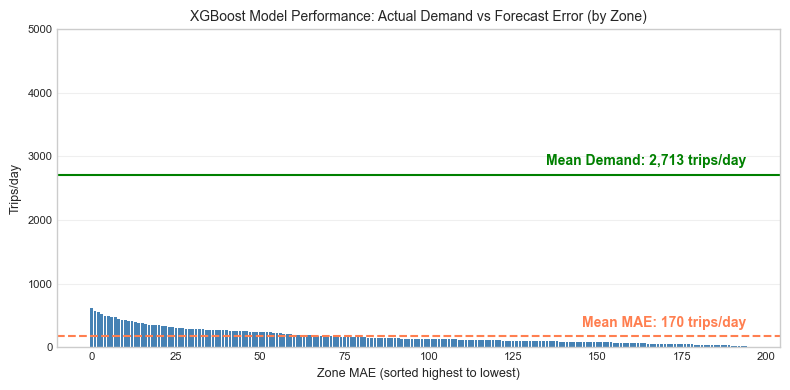

In [35]:
# Visualize MAE distribution across zones with demand 

fig, ax = plt.subplots(figsize=(8, 4))

sorted_results_df = zone_summary_df.sort_values('MAE', ascending=False)
ax.bar(range(len(sorted_results_df)), sorted_results_df['MAE'], color='steelblue')

# Mean demand line with label
ax.axhline(overall_mean_demand, color='green', linestyle='-')
ax.text(len(sorted_results_df) - 1, overall_mean_demand + 100, 
        f"Mean Demand: {overall_mean_demand:,.0f} trips/day", 
        ha='right', va='bottom', color='green', fontweight='bold')

# Mean MAE line with label
ax.axhline(zone_summary_df['MAE'].mean(), color='coral', linestyle='--')
ax.text(len(sorted_results_df) - 1, zone_summary_df['MAE'].mean() + 100, 
        f"Mean MAE: {zone_summary_df['MAE'].mean():,.0f} trips/day", 
        ha='right', va='bottom', color='coral', fontweight='bold')

ax.set_xlabel('Zone MAE (sorted highest to lowest)')
ax.set_ylabel('Trips/day')
ax.set_ylim(0, 5000)
ax.set_title('XGBoost Model Performance: Actual Demand vs Forecast Error (by Zone)')

plt.tight_layout()
plt.show()

**Results:**
- The chart shows XGBoost achieves strong performance across all zones
- The **mean forecast error:** 166 trips/day (6.6% of mean demand)
- **High-volume zones** have larger absolute errors but show similar percentage errors
- **XGBoost generalizes well** with the gap between actual demand and forecast error consistent across zones

In [36]:
# Validate forecast quality
assert overall_mape < 15, f"MAPE {overall_mape:.1f}% exceeds acceptable threshold"
assert zone_summary_df['MAE'].min() > 0, "Invalid MAE values"
assert zone_summary_df['zone_id'].nunique() == forecast_df['zone_id'].nunique(), "Missing zones in results"

### 9.2 Analyze Error Distribution
Visualize MAPE distribution across zones to assess model consistency.

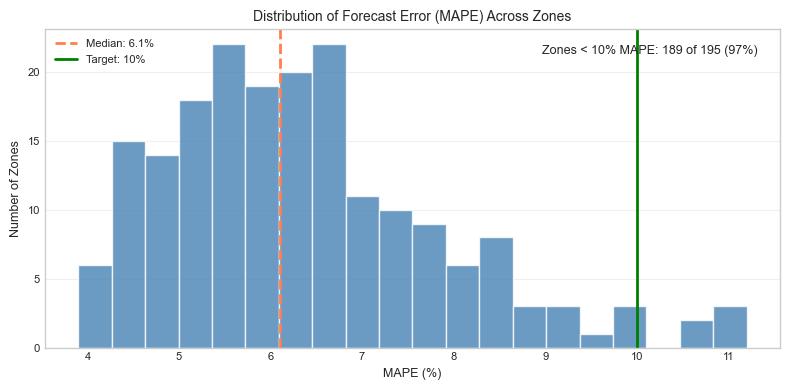

In [37]:
# Visualize MAPE distribution across zones

fig, ax = plt.subplots(figsize=(8, 4))

ax.hist(zone_summary_df['MAPE'], bins=20, color='steelblue', edgecolor='white', alpha=0.8)
ax.axvline(zone_summary_df['MAPE'].median(), color='coral', linestyle='--', linewidth=2, 
           label=f"Median: {zone_summary_df['MAPE'].median():.1f}%")
ax.axvline(10, color='green', linestyle='-', linewidth=2, 
           label="Target: 10%")

ax.set_xlabel('MAPE (%)')
ax.set_ylabel('Number of Zones')
ax.set_title('Distribution of Forecast Error (MAPE) Across Zones')
ax.legend()

# Add summary stats as text
stats_text = f"Zones < 10% MAPE: {(zone_summary_df['MAPE'] < 10).sum()} of {len(zone_summary_df)} ({(zone_summary_df['MAPE'] < 10).mean()*100:.0f}%)"
ax.text(0.97, 0.95, stats_text, transform=ax.transAxes, ha='right', va='top', fontsize=9)

plt.tight_layout()
plt.show()

**Results:**
- The histogram shows model performance is consistent across zones
- Most zones are clustered near the median
- Green line = 10% MAPE target
- A small number of zones in the right tail may have irregular demand patterns not well captured by weekly lag features

## Conclusion

This analysis successfully developed a one-day-ahead demand forecasting model for NYC rideshare zones, achieving the <10% MAPE target across 97% of zones in the model dataset.

**Key Findings:**

- **XGBoost achieved 6.4% MAPE** across 195 zones representing 82% of total rideshare trips
- **97% of zones met the <10% MAPE target**, demonstrating consistent model performance
- **Pilot zone testing** confirmed XGBoost (5.1% MAPE) outperformed both baseline (7.1%) and Prophet (13.2%)
- **Lag-based features effectively captured weekly patterns** identified in EDA

**Modeling Approach:**

- Tested three models on pilot zone before scaling
- Lag features (1-day, 7-day) captured weekly demand patterns
- Recent demand levels proved more predictive than long-term trend extrapolation

**Limitations:**

- One-day-ahead only — keeps initial analysis straightforward, but may not be as useful as 1-2 week horizons for driver scheduling
- Prophet may be worth re-evaluating for longer forecast horizons
- Multi-day forecasting is a natural next step

**Outputs:**
- `forecast_results.csv` — Daily predictions with actual values and errors
- `summary_results.csv` — Zone-level performance metrics

**Next Steps:**
- Extend to multi-day forecast horizons (1-7 days)
- Develop specialized models for low-correlation zones (airports, entertainment districts)
- Add cross-validation and hyperparameter tuning
- Incorporate statistical testing for model comparison

## References

- Hyndman, R.J., & Athanasopoulos, G. (2021). *Forecasting: Principles and Practice* (3rd ed.). https://otexts.com/fpp3/
- Makridakis, S., Spiliotis, E., & Assimakopoulos, V. (2022). M5 accuracy competition: Results, findings, and conclusions. *International Journal of Forecasting*, 38(4), 1346-1364.
- Taylor, S.J., & Letham, B. (2018). Forecasting at Scale. *The American Statistician*, 72(1), 37-45.

---

## Appendix: Export Results
Export forecast and summary files for dashboard and reporting.

### A.1 Calculate Export Metrics
Add error calculations and context columns for analysis.

In [38]:
# Calculate error metrics and context columns for Tableau export

# Error calculations
forecast_df['error'] = forecast_df['forecast'] - forecast_df['actual']
forecast_df['abs_error'] = forecast_df['error'].abs()
forecast_df['pct_error'] = (forecast_df['abs_error'] / forecast_df['actual'] * 100).round(2)

# Zone context
forecast_df = forecast_df.merge(
    zone_summary_df[['zone_id', 'zone_mean']], 
    on='zone_id', 
    how='left'
)

# Week-over-week change
forecast_df = forecast_df.sort_values(['zone_id', 'date'])
forecast_df['forecast_wow_change'] = (
    forecast_df.groupby('zone_id')['forecast']
    .pct_change(7) * 100
).round(1)

# Forecast vs zone baseline
forecast_df['vs_zone_mean_pct'] = (
    (forecast_df['forecast'] - forecast_df['zone_mean']) / forecast_df['zone_mean'] * 100
).round(1)

print("Derived columns added")

Derived columns added


### A.2 Add Zone Metadata
Merge zone names and borough information.

In [39]:
zone_metadata_df.head()

,zone_id,Borough,Zone,service_zone
0,1,EWR,Newark Airport,EWR
1,2,Queens,Jamaica Bay,Boro Zone
2,3,Bronx,Allerton/Pelham Gardens,Boro Zone
3,4,Manhattan,Alphabet City,Yellow Zone
4,5,Staten Island,Arden Heights,Boro Zone


In [40]:
# Add zone names and borough for geographic filtering

forecast_df = forecast_df.merge(
   zone_metadata_df[['zone_id', 'Zone', 'Borough']], 
     on='zone_id', 
     how='left'
 )
# Rename fields for consistency 
forecast_df = forecast_df.rename(columns={'Zone': 'zone_name', 'Borough': 'borough'})
forecast_df.head()

,zone_id,date,actual,forecast,day_name,is_weekend,is_holiday,month,season,residual,error,abs_error,pct_error,zone_mean,forecast_wow_change,vs_zone_mean_pct,zone_name,borough
0,3,2024-07-01,1233,1381.8408,Monday,False,False,7,summer,-148.8408,148.8408,148.8408,12.0700,1406.5054,NaN,-1.8000,Allerton/Pelham Gardens,Bronx
1,3,2024-07-02,1274,1311.1003,Tuesday,False,False,7,summer,-37.1003,37.1003,37.1003,2.9100,1406.5054,NaN,-6.8000,Allerton/Pelham Gardens,Bronx
2,3,2024-07-03,1322,1423.0117,Wednesday,False,False,7,summer,-101.0117,101.0117,101.0117,7.6400,1406.5054,NaN,1.2000,Allerton/Pelham Gardens,Bronx
3,3,2024-07-04,1342,1267.9722,Thursday,False,True,7,summer,74.0278,-74.0278,74.0278,5.5200,1406.5054,NaN,-9.8000,Allerton/Pelham Gardens,Bronx
4,3,2024-07-05,1523,1541.7843,Friday,False,False,7,summer,-18.7843,18.7843,18.7843,1.2300,1406.5054,NaN,9.6000,Allerton/Pelham Gardens,Bronx


### A.3 Export Forecast Results
Save detailed daily forecasts with error metrics to CSV.

In [41]:
# Save production-ready forecast dataset

# Column selection and ordering
export_columns = [
    # Identifiers
    'zone_id', 'zone_name', 'borough', 'date',
    # Core metrics
    'actual', 'forecast', 'error', 'abs_error', 'pct_error',
    # Context
    'zone_mean', 'vs_zone_mean_pct', 'forecast_wow_change',
    # Time dimensions
    'day_name', 'is_weekend', 'is_holiday', 'month', 'season'
]

export_cols = [c for c in export_columns if c in forecast_df.columns]
forecast_results_df = forecast_df[export_cols].copy()

# Save
forecast_results_df.to_csv(RESULTS_DIR / "forecast_results.csv", index=False)

print("\nFORECAST RESULTS EXPORT")
print(f"File: forecast_results.csv")
print(f"Zones: {forecast_results_df['zone_id'].nunique()}")
print(f"Date range: {forecast_results_df['date'].min()} to {forecast_results_df['date'].max()}")
print(f"Records: {len(forecast_results_df):,}")


FORECAST RESULTS EXPORT
File: forecast_results.csv
Zones: 195
Date range: 2024-07-01 00:00:00 to 2024-12-31 00:00:00
Records: 35,880


### A.4 Export Summary Results
Save aggregated zone-level performance metrics to CSV.

In [42]:
# Export zone-level metrics in separate file

zone_summary_df.to_csv(RESULTS_DIR / "summary_results.csv", index=False)

print("\nSUMMARY RESULTS EXPORT")
print(f"File: summary_results.csv")
print(f"Zones: {zone_summary_df['zone_id'].nunique()}")
print(f"Metrics: MAE, MAPE, zone_mean")
print(f"Records: {len(zone_summary_df):,}")


SUMMARY RESULTS EXPORT
File: summary_results.csv
Zones: 195
Metrics: MAE, MAPE, zone_mean
Records: 195
